# Worksheet 17

Name:  Haodong Xu  
UID: U76388567

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

I will use a binary classification model to predict whether a user will like a movie or not. I will use the user's past likes and dislikes to train the model. I will then use the model to predict whether the user will like a movie or not. The higher the predicted probability of the user liking a movie, the higher the recommendation it would be.

b) Describe 3 challenges of building a recommender system

1. The recommender system will suffer from cold start. If a user has not rated many movies, it is difficult to predict what they will like.
2. If the dataset is sparse, it is difficult to find similar users or items.
3. The recommender system may suffer from a lot of biases. For example, if a user has only rated movies from a certain genre, the recommender system may only recommend movies from that genre. Also, ratings from different users may be on different scales, making itself biased towards users who rate movies higher or lower.

c) Why is SVD not an option for collaborative filtering?

SVD requires a fully populated matrix. And in collaborative filtering, the matrix of rating is usually sparse. SVD will not work well with a sparse matrix.

d) Use the code below to train a recommender system on a dataset of amazon movies

Kaggle RMSE =  3.3084135170803544


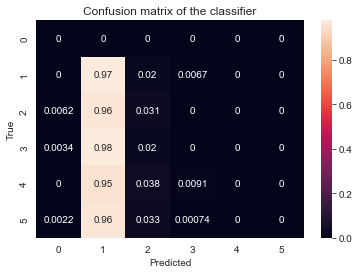

In [30]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
# param_grid = ParamGridBuilder().addGrid(
        # als.rank, [10, 50]).addGrid(
        # als.regParam, [.1]).addGrid(
        # # als.maxIter, [10]).build()
# evaluator = RegressionEvaluator(
        # metricName="rmse",
        # labelCol="Score", 
        # # predictionCol="prediction")
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
# cv_fit = cv.fit(df)
# rec_sys = cv_fit.bestModel

rec_sys = als.fit(df)
# rec_sys.save('rec_sys.obj') # so we don't have to re-train it
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']]))
rec_pd = rec.toPandas()
X_test_processed = X_test_processed.merge(rec_pd[['UserId_fact', 'ProductId_fact', 'prediction']],
                                          how='left',
                                          on=['UserId_fact', 'ProductId_fact'])
X_test_processed.rename(columns={'prediction': 'Score'}, inplace=True)
# Use the mean of the training set to fill in missing values to handle the cold start problem.
X_test_processed['Score'].fillna(X_test_processed['Score'].mean(), inplace=True)
# Since all ratings are integers, round the predictions to the nearest integer.
X_test_processed['Score'] = X_test_processed['Score'].round().astype(int)




print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

cm = confusion_matrix(Y_test, X_test_processed['Score'], normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()